# This is how a neural network learns to add, multiply and compare handwritten digits WITHOUT knowing their values 

<p align="center"> <img src="https://i.dlpng.com/static/png/6906777_preview.png"> </p>   

I described in a [previous post](https://blog.jovian.ai/how-to-train-supervised-machine-learning-algorithms-without-labeled-data-6ebddc01a00f), how useful are autoencoders in  automated labeling. The main property of these networks is their ability to learn features/patterns in the data. This is in fact not specific to autoencoders and can be implemented using other unsupervised techniques, mainly **PCA**.  
The ability to detect and learn features in data can be used in other areas.  

In this post, I will present some applications of convolutional autoencoders:  
- First, a convolutional autoencoder will be trained on **MNIST** data.
- After the training of the encoder and decoder, we will freeze their weights and use them with additional dense layers to "learn" arithmetic operations, namely addition, multiplication and comparison.  
The trick is to *never* explicitly associate the handwritten digits in **MNIST** dataset with their respective labels. We will see that the neural networks will be nevertheless able to reach 97+% accuracy in all cases on unseen data.

The first step is described in the following diagram:
<p align="center"> <img src="https://i.imgur.com/chLUEdp.png"> </p>   

In the second step, we will use the encoder in series with dense layers to perform arithmetic operations: addition, multiplication and comparison. We will train only the dense layer weights, and supply the results of the operations as labels. note that we will not supply the digits values (labels).

<p align="center"> <img src="https://i.imgur.com/s8U8up4.png"> </p> 


# Training an autoencoder on MNIST data

Similar to the previous article, we will use MNIST data in this experiment. The autoencoder will learn the handwritten digits features using 60000 training samples. We import MNIST using *KERAS* library.

In [1]:
#import libraries and setup 
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger('tensorflow').disabled = True
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)

In [2]:
# import mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape,y_train.shape)

(60000, 28, 28) (60000,)


We scale the data in the range `[0,1]` and reshape it to *KERAS* format for pictures (nbr_samples x width x height x channels) 

In [3]:
#normalize data
if x_train.max() >1:
    x_train = x_train / 255
    x_test = x_test / 255

default_shape = x_train.shape
#reshape input data to 1 channel
x_train = x_train.reshape(-1,default_shape[1],default_shape[2],1)
x_test = x_test.reshape(-1,default_shape[1],default_shape[2],1)
image_dim = x_train.shape[1:]

We will implement a similar autoencoder architecture as in [[1]](https://blog.jovian.ai/how-to-train-supervised-machine-learning-algorithms-without-labeled-data-6ebddc01a00f). It is based on a series of convolutional layers, that will gradually encode the 28x28 image (784 pixel) into a 100 elements array, and decode that representation back to the original format. The resulting image -after the training step- will hopefully resemble to the original one.

In [4]:
# create an autoencoder / decoder 
encoder = Sequential()
encoder.add(Conv2D(32,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu',input_shape=image_dim))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same',activation='selu'))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same',activation='selu'))
encoder.add(Flatten())
encoder.add(Dense(100,activation='sigmoid'))
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               6

In [5]:
encoder_out_dim = encoder.layers[-1].output_shape[1:] # dimension of the encoder output

In [6]:
decoder = Sequential()
decoder.add(Dense(6272, activation='sigmoid', input_shape=encoder_out_dim))
decoder.add(Reshape(( 7, 7, 128)))
decoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(1,kernel_size=(3,3), strides=(1,1),padding='same', activation='sigmoid'))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)        

The autoencoder is created using the encoder and the decoder:

In [7]:
enc_dec = Sequential([encoder,decoder])
enc_dec.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100)               719972    
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         855425    
Total params: 1,575,397
Trainable params: 1,575,397
Non-trainable params: 0
_________________________________________________________________


It will be trained as a set of binary classifiers for each pixel.

In [8]:
enc_dec.compile(optimizer='nadam', loss = 'binary_crossentropy')
history = enc_dec.fit(x_train,x_train, batch_size=100,epochs=1000,validation_split=0.2, verbose=2,callbacks=[es,es])

Epoch 1/1000
480/480 - 15s - loss: 0.2821 - val_loss: 0.2675
Epoch 2/1000
480/480 - 15s - loss: 0.2642 - val_loss: 0.2636
Epoch 3/1000
480/480 - 14s - loss: 0.2373 - val_loss: 0.1565
Epoch 4/1000
480/480 - 14s - loss: 0.1306 - val_loss: 0.1181
Epoch 5/1000
480/480 - 14s - loss: 0.1148 - val_loss: 0.1116
Epoch 6/1000
480/480 - 14s - loss: 0.1094 - val_loss: 0.1076
Epoch 7/1000
480/480 - 14s - loss: 0.1061 - val_loss: 0.1061
Epoch 8/1000
480/480 - 14s - loss: 0.1041 - val_loss: 0.1033
Epoch 9/1000
480/480 - 14s - loss: 0.1023 - val_loss: 0.1029
Epoch 10/1000
480/480 - 14s - loss: 0.1009 - val_loss: 0.1014
Epoch 11/1000
480/480 - 14s - loss: 0.0999 - val_loss: 0.1003
Epoch 12/1000
480/480 - 14s - loss: 0.0991 - val_loss: 0.1013
Epoch 13/1000
480/480 - 15s - loss: 0.0983 - val_loss: 0.1003
Epoch 14/1000
480/480 - 15s - loss: 0.0976 - val_loss: 0.0993
Epoch 15/1000
480/480 - 14s - loss: 0.0969 - val_loss: 0.0977
Epoch 16/1000
480/480 - 14s - loss: 0.0964 - val_loss: 0.0974
Epoch 17/1000
480

The early stopping will make sure the autoencoder will not overfit the training data. There are two ways to verify the network. First, we can evaluate the loss function on test data, and expect it to be close to the loss value on the training data.

In [9]:
enc_dec.evaluate(x_test,x_test,batch_size=1000)

10/10 [==============================] - 1s 71ms/step - loss: 0.0882


0.08822797983884811

In [10]:
enc_dec.evaluate(x_train,x_train,batch_size=1000)

60/60 [==============================] - 5s 77ms/step - loss: 0.0852


0.08517985045909882

It is very close, around `0.08` for both data sets. The second method is to check the resulting reconstitution that we obtain for a random sample from the test data.

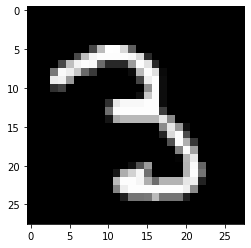

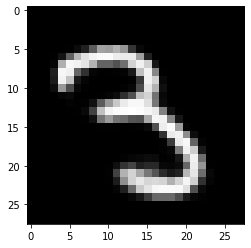

In [11]:
random_label = np.random.randint(0,9999)
img_sample = x_test[random_label,:,:].reshape((1,28,28,1))
plt.imshow(img_sample.reshape(28,28), cmap='gray');
pred_img = enc_dec.predict(img_sample) 
plt.figure();
plt.imshow(pred_img.reshape(28,28), cmap='gray');

*A picture is worth a thousand words!*

In [12]:
# save models
encoder.save('encoder')
decoder.save('decoder')

Now we have a trained encoder and decoder, let's focus on the *encoder*. For each image, is associated a representation that captures most of the interesting features. This representation is sufficient to reconstitute the image using the decoder. Here is the representation of the sample image we used earlier: 

In [13]:
representation_sample = encoder.predict(img_sample)
print(representation_sample) 

[[0.0000000e+00 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.6840684e-17
  1.0000000e+00 0.0000000e+00 0.0000000e+00 2.7144099e-35 1.0000000e+00
  1.0000000e+00 6.2723314e-36 1.0000000e+00 1.5508051e-11 1.0000000e+00
  0.0000000e+00 1.0364077e-03 1.2028039e-09 0.0000000e+00 5.5973729e-08
  0.0000000e+00 3.0960938e-13 0.0000000e+00 0.0000000e+00 1.1984192e-08
  0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00 0.0000000e+00
  1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00 0.0000000e+00
  3.9332832e-11 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
  1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00 0.0000000e+00
  1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1253273e-06
  3.9418192e-24 0.0000000e+00 8.3602914e-15 0.0000000e+00 0.0000000e+00
  1.0000000e+00 1.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000

Using these 100 numbers, we generate a 28x28 image (784 pixels).

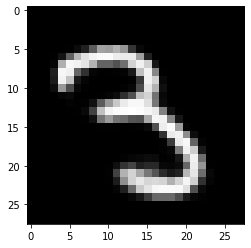

In [14]:
recons_image = decoder.predict(representation_sample)
plt.imshow(recons_image.reshape(28,28), cmap='gray');

And here is where the *fun part* begins! using the lower-dimension representation, let's do some math.

# Learning arithmetic operations on handwritten digits

The idea is simple. Using the representation of two images, we train a neural network to compute their sum, product and to compare them. We will not provide the value of each digit, but we will provide the results during the training step.  
We will be performing addition and multiplication between numbers in the range [0-9]. The results will be in the range [0-18] and [0-81] respectively. So the results will be coded using multiple outputs:  
1- Sum Units, multiclass output [0,1,2,3,4,5,6,7,8,9]  
2- Sum tens, binary output [0,1]  
3- Multiplication Units, multiclass output [0,1,2,3,4,5,6,7,8,9]  
4- Multiplication tens, multiclass output [0,1,2,3,4,5,6,7,8]  
5- Comparison, binary output [0,1]  


<p align="center"> <img src="https://i.imgur.com/E5unC7Y.png"> </p> 


Using the functional API in *KERAS* we define the network architecture. First, we import the encoder *twice* and freeze its weights:

In [15]:
# duplicate encoders and freeze weights
encoder1 = keras.models.load_model('encoder') 
encoder1._name = 'encoder1'
encoder1.trainable = False

encoder2 = keras.models.load_model('encoder')
encoder2._name = 'encoder2'
encoder2.trainable = False

Using the encoders, we build the model:

In [16]:
# create model to learn it all
input1 = Input(shape=image_dim)
input2 = Input(shape=image_dim)
enc1_out = encoder1(input1)
enc2_out = encoder2(input2)
model_c = Concatenate()([enc1_out,enc2_out])
model_c = Dense(1000,activation='relu')(model_c)

model_b1 = Dense(200,activation='relu')(model_c)
model_b2 = Dense(200,activation='relu')(model_c)
model_b3 = Dense(200,activation='relu')(model_c)
model_b4 = Dense(200,activation='relu')(model_c)
model_b5 = Dense(200,activation='relu')(model_c)



units_add =  Dense(10,activation='softmax',name ='units_add')(model_b1)
tens_add = Dense(1,activation='sigmoid',name ='tens_add')(model_b2)

units_mult =  Dense(10,activation='softmax',name ='units_mult')(model_b3)
tens_mult = Dense(9,activation='softmax',name ='tens_mult')(model_b4)

comp =  Dense(1,activation='sigmoid',name ='comp')(model_b5)



model_complete = Model(inputs=[input1,input2],outputs=[units_add,tens_add,units_mult,tens_mult,comp])

model_complete.compile(optimizer='nadam', loss = ['categorical_crossentropy','binary_crossentropy','categorical_crossentropy','categorical_crossentropy','binary_crossentropy'], metrics=['acc'])

This model has two inputs (the two handwritten digits images) and five outputs (units and tens of the sum and product plus the comparsion result). We will use two different losses due to the nature of the outputs. Note that there is a common hidden layer of 1000 units, and then five branches (one for each output).  
We need to create datasets to train and test our model. Inputs will be random combinations of handwritten digits. Outputs will be the expected results for each combination. 

In [17]:
# generate a dataset for additions
train_size = 500000
random_labels1 = np.random.randint(0,25000,train_size)
random_labels2 = np.random.randint(0,25000,train_size)

x_train_1 = x_train[random_labels1]
x_train_2 = x_train[random_labels2]

y_train_1 = y_train[random_labels1]
y_train_2 = y_train[random_labels2]

y_add = y_train_1 + y_train_2
y_add_tens = y_add //10 
y_add_units = y_add %10 
y_add_units_cat = to_categorical(y_add_units)


# the same with x_test
test_size = 5000
random_labels1 = np.random.randint(0,10000,test_size)
random_labels2 = np.random.randint(0,10000,test_size)

x_test_1 = x_test[random_labels1]
x_test_2 = x_test[random_labels2]

y_test_1 = y_test[random_labels1]
y_test_2 = y_test[random_labels2]

y_test_add = y_test_1 + y_test_2
y_test_add_tens = y_test_add //10 
y_test_add_units = y_test_add %10 
y_test_add_units_cat = to_categorical(y_test_add_units)

# generate a dataset for multiplication

y_mult = y_train_1 * y_train_2
y_mult_tens = y_mult //10 
y_mult_units = y_mult %10 
y_mult_units_cat = to_categorical(y_mult_units)
y_mult_tens_cat = to_categorical(y_mult_tens)

# the same with x_test

y_test_mult = y_test_1 * y_test_2
y_test_mult_tens = y_test_mult //10 
y_test_mult_units = y_test_mult %10 
y_test_mult_units_cat = to_categorical(y_test_mult_units)
y_test_mult_tens_cat = to_categorical(y_test_mult_tens)

# generate a dataset for comparison
y_comp = y_train_1 > y_train_2

# the same with x_test
y_test_comp = y_test_1 > y_test_2

Now we are ready to train our model! 

In [18]:
history = model_complete.fit([x_train_1,x_train_2],[y_add_units_cat,y_add_tens,y_mult_units_cat,y_mult_tens_cat,y_comp], batch_size=1000,epochs=1000,validation_split=0.2, verbose=1,callbacks=[es,es,es,es,es,es])

Epoch 1/1000
400/400 [==============================] - 31s 77ms/step - loss: 3.6060 - units_add_loss: 1.2366 - tens_add_loss: 0.3254 - units_mult_loss: 0.9394 - tens_mult_loss: 0.7870 - comp_loss: 0.3175 - units_add_acc: 0.5868 - tens_add_acc: 0.8517 - units_mult_acc: 0.6771 - tens_mult_acc: 0.7189 - comp_acc: 0.8551 - val_loss: 1.7964 - val_units_add_loss: 0.5861 - val_tens_add_loss: 0.1868 - val_units_mult_loss: 0.4516 - val_tens_mult_loss: 0.3929 - val_comp_loss: 0.1790 - val_units_add_acc: 0.8174 - val_tens_add_acc: 0.9246 - val_units_mult_acc: 0.8553 - val_tens_mult_acc: 0.8673 - val_comp_acc: 0.9296
Epoch 2/1000
400/400 [==============================] - 30s 75ms/step - loss: 1.2846 - units_add_loss: 0.4152 - tens_add_loss: 0.1350 - units_mult_loss: 0.3276 - tens_mult_loss: 0.2757 - comp_loss: 0.1311 - units_add_acc: 0.8730 - tens_add_acc: 0.9490 - units_mult_acc: 0.8956 - tens_mult_acc: 0.9096 - comp_acc: 0.9504 - val_loss: 0.9736 - val_units_add_loss: 0.3122 - val_tens_add_los

At the end of the training, the accuracy on all outputs is pretty good (9x%). Let's see first how the model performs on the test data.

In [19]:
test = model_complete.evaluate([x_test_1,x_test_2],[y_test_add_units_cat,y_test_add_tens,y_test_mult_units_cat,y_test_mult_tens_cat,y_test_comp], batch_size=100)

50/50 [==============================] - 1s 11ms/step - loss: 2.4764 - units_add_loss: 0.7290 - tens_add_loss: 0.2871 - units_mult_loss: 0.6328 - tens_mult_loss: 0.5221 - comp_loss: 0.3055 - units_add_acc: 0.9140 - tens_add_acc: 0.9646 - units_mult_acc: 0.9292 - tens_mult_acc: 0.9416 - comp_acc: 0.9640


Results are still in the 9x%. We can show a random sample of the model predictions.

sum = [[12.]]
multiplication result = 32
comparison result = [[0.]] 1 if the number on the left is greater, 0 elsewhere


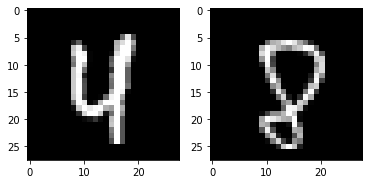

In [26]:
random_label_1 = np.random.randint(0,9999)
random_label_2 = np.random.randint(0,9999)

img_sample1 = x_test[random_label_1,:,:].reshape((1,28,28,1))
img_sample2 = x_test[random_label_2,:,:].reshape((1,28,28,1))

plt.subplot(1,2,1)
plt.imshow(img_sample1.reshape(28,28), cmap='gray');

plt.subplot(1,2,2)
plt.imshow(img_sample2.reshape(28,28), cmap='gray');

prediction = model_complete.predict([img_sample1,img_sample2])
unit_add = prediction[0]
ten_add = prediction[1]
unit_mult = prediction[2]
ten_mult = prediction[3]
comp_images = prediction[4]

sum_images = np.argmax(unit_add)+10*np.round(ten_add)
print('sum =',sum_images)


mult_images = np.argmax(unit_mult)+10*np.argmax(ten_mult)
print('multiplication result =',mult_images)

print('comparison result =',np.round(comp_images),'1 if the number on the left is greater, 0 elsewhere')

Results look promising! We actually could improve the accuracy by training the model on more random samples (increase `train_size` value) or tweak the model architecture. One last thing: save the model!

In [21]:
# save the model
model_complete.save('model_complete')

# Conclusion and future work